# Multi-Armed Bandits and Reinforcement Learning with Amazon SageMaker

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [AWS Reinforcement Learning Container](https://github.com/aws/sagemaker-rl-container) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

![](img/multi_armed_bandit_maximize_reward.png)

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

# Relevant Links

In-Practice
* [AWS Blog Post on Contextual Multi-Armed Bandits](https://aws.amazon.com/blogs/machine-learning/power-contextual-bandits-using-continual-learning-with-amazon-sagemaker-rl/)
* [Multi-Armed Bandits at StitchFix](https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/)
* [Introduction to Contextual Bandits](https://getstream.io/blog/introduction-contextual-bandits/)
* [Vowpal Wabbit Contextual Bandit Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms)

Theory
* [Learning to Interact](https://hunch.net/~jl/interact.pdf)
* [Contextual Bandit Bake-Off](https://arxiv.org/pdf/1802.04064.pdf)
* [Doubly-Robust Policy Evaluation and Learning](https://arxiv.org/pdf/1103.4601.pdf)

Code
* [AWS Open Source Reinforcement Learning Containers](https://github.com/aws/sagemaker-rl-container)
* [AWS Open Source Bandit Experiment Manager](./common/sagemaker_rl/orchestrator/workflow/manager)
* [Vowpal Wabbit Reinforcement Learning Framework](https://github.com/VowpalWabbit/)

# AWS Open Source Bandit `ExperimentManager` Library

![](img/multi_armed_bandit_traffic_shift.png)

The bandit model is implemented by the open source [**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) provided with this example.  This This implementation continuously updates a Vowpal Wabbit reinforcement learning model using Amazon SageMaker, DynamoDB, Kinesis, and S3.

The client application, a recommender system with a review service in our case, pings the SageMaker hosting endpoint that is serving the bandit model.  The application sends the an `event` with the `context` (ie. user, product, and review text) to the bandit model and receives a recommended action from the bandit model.  In our case, the action is 1 of 2 BERT models that we are testing.  The bandit model stores this event data (given context and recommended action) in S3 using Amazon Kinesis.  _Note:  The context makes this a "contextual bandit" and differentiates this implementation from a regular multi-armed bandit._

The client application uses the recommended BERT model to classify the review text as star rating 1 through 5 and  compares the predicted star rating to the user-selected star rating.  If the BERT model correctly predicts the star rating of the review text (ie. matches the user-selected star rating), then the bandit model is rewarded with `reward=1`.  If the BERT model incorrectly classifies the star rating of the review text, the bandit model is not rewarded (`reward=0`).

The client application stores the rewards data in S3 using Amazon Kinesis.  Periodically (ie. every 100 rewards), we incrementally train an updated bandit model with the latest the reward and event data.  This updated bandit model is evaluated against the current model using a holdout dataset of rewards and events.  If the bandit model accuracy is above a given threshold relative to the existing model, it is automatically deployed in a blue/green manner with no downtime.  SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA).  By default, we apply [**doubly robust (DR) estimation**](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit model tries to minimize the cost (`1 - reward`), so a smaller evaluation score indicates better bandit model performance.

Unlike traditional A/B tests, the bandit model will learn the best BERT model (action) for a given context over time and begin to shift traffic to the best model.  Depending on the aggressiveness of the bandit model algorithm selected, the bandit model will continuously explore the under-performing models, but start to favor and exploit the over-performing models.  And unlike A/B tests, multi-armed bandits allow you to add a new action (ie. BERT model) dynamically throughout the life of the experiment.  When the bandit model sees the new BERT model, it will start sending traffic and exploring the accuracy of the new BERT model - alongside the existing BERT models in the experiment.

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of the SageMaker training and hosting cluster instances.  The workflow remains the same in `local_mode`, but runs much faster for small datasets.  Hence, it is a useful tool for experimenting and debugging.  However, it will not scale to production use cases with high throughput and large datasets.  In `local_mode`, the training, evaluation, and hosting is done in the local [SageMaker Vowpal Wabbit Docker Container](https://github.com/aws/sagemaker-rl-container).

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
%store -r tensorflow_endpoint_name

In [3]:
try:
    tensorflow_endpoint_name
    print('[OK]')
except NameError:
    print('+++++++++++++++++++++++++++++++')
    print('[ERROR] Please run the notebooks in this section before you continue.')
    print('+++++++++++++++++++++++++++++++')

[OK]


In [4]:
print(tensorflow_endpoint_name)

tensorflow-training-2020-11-12-04-21-00-570-tf-1605200530


In [5]:
%store -r pytorch_endpoint_name

In [6]:
try:
    pytorch_endpoint_name
    print('[OK]')    
except NameError:
    print('+++++++++++++++++++++++++++++++')
    print('[ERROR] Please run the notebooks in this section before you continue.')
    print('+++++++++++++++++++++++++++++++')

[OK]


In [7]:
print(pytorch_endpoint_name)

tensorflow-training-2020-11-12-04-21-00-570-pt-1605216266


# Configure the 2 BERT Models to Test with our Bandit Experiment

Now that the last trained bandit model is deployed as a SageMaker Endpoint, the client application will send the context to the endpoint and receive the recommended action.  The bandit model will recommend 1 of 2 actions in our example:  `1` or `2` which correspond to BERT model 1 and BERT model 2, respectively.  Let's configure these 2 BERT models below.

In [8]:
model_1_endpoint_name = tensorflow_endpoint_name

In [9]:
print(model_1_endpoint_name)

tensorflow-training-2020-11-12-04-21-00-570-tf-1605200530


In [10]:
try:
    waiter = sm.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=model_1_endpoint_name)
except:
    print('###################')
    print('The endpoint is not running.')
    print('Please re-run the previous section to deploy the endpoint.')
    print('###################')    

In [11]:
import json
from sagemaker.tensorflow.model import TensorFlowPredictor

model1 = TensorFlowPredictor(endpoint_name=model_1_endpoint_name,
                             sagemaker_session=sess,
                             model_name='saved_model',
                             model_version=0)

In [12]:
review = 'This is great!'

model1_predicted_class = model1.predict(review)[0]

print('[Predicted Star Rating: {}]'.format(model1_predicted_class), review)

[Predicted Star Rating: 5] This is great!


In [13]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [14]:
model_2_endpoint_name = pytorch_endpoint_name

In [15]:
print(model_2_endpoint_name)

tensorflow-training-2020-11-12-04-21-00-570-pt-1605216266


In [16]:
try:
    waiter = sm.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=model_2_endpoint_name)
except:
    print('###################')
    print('The endpoint is not running.')
    print('Please re-run the previous section to deploy the endpoint.')
    print('###################')    

In [17]:
import json
from sagemaker.predictor import Predictor

model2 = Predictor(endpoint_name=model_2_endpoint_name,
                   sagemaker_session=sess)

In [18]:
review = 'This is great!'

model2_predicted_class = model2.predict(review).decode('utf-8')

print('[Predicted Star Rating: {}]'.format(model2_predicted_class), review)

[Predicted Star Rating: 5] This is great!


In [19]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


In [20]:
import yaml
import sys
import numpy as np
import time
import sagemaker

sys.path.append('common')
sys.path.append('common/sagemaker_rl')

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `s3://sagemaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

The Docker image is defined here:  https://github.com/aws/sagemaker-rl-container/blob/master/vw/docker/8.7.0/Dockerfile

In [22]:
!pygmentize 'config.yaml'

resource:
  shared_resource:
    resources_cf_stack_name: "BanditsSharedResourceStack" # cloud formation stack
    experiment_db:
      table_name: "BanditsExperimentTable" # Dynamo table for status of an experiment
    model_db:
      table_name: "BanditsModelTable" # Dynamo table for status of all models trained
    join_db:
      table_name: "BanditsJoinTable" # Dynamo table for status of all joining job for reward ingestion
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu" # Vowpal Wabbit container
algor: # Vowpal Wabbit algorithm parameters
  algorithms_parameters:
    exploration_policy: "cover" # supports "egreedy", "bag", "cover"
    epsilon: 0.10 # percent to explore with e

In [23]:
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

# Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [24]:
# from markdown_helper import *
# from IPython.display import Markdown

# display(Markdown(generate_help_for_experiment_manager_permissions(role)))

### Client Application (Environment)
The client application simulates a live environment that uses the bandit model to recommend a BERT model to classify review text submitted by the application user. 

The logic of reward generation resides in the client application.  We simulate the online learning loop with feedback.  The data consists of 2 actions - 1 for each BERT model under test.  If the bandit model selects the right class, then the model is rewarded with `reward=1`.  Otherwise, the bandit model receives `reward=0`.

The workflow of the client application is as follows:
- Our client application picks sample review text at random, which is sent to the bandit model (SageMaker endpoint) to recommend an action (BERT model) to classify the review text into star rating 1 through 5.
- The bandit model returns an action, an action probability, and an `event_id` for this prediction event.
- Since the client application uses the Amazon Customer Reviews Dataset, we know the true star rating for the review text
- The client application compares the predicted and true star rating and assigns a reward to the bandit model using Amazon Kinesis, S3, and DynamoDB.  (The `event_id` is used to join the event and reward data.)

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action_probability>` with the reward data. 

In a later cell of this notebook, we illustrate how the client application interacts with the bandit model endpoint and receives the recommended action (BERT model).

### Step-by-step bandits model development

[**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [25]:
import time
timestamp = int(time.time())

experiment_name = 'bandits-{}'.format(timestamp)

# `ExperimentManager` will create a AWS CloudFormation Stack of additional resources needed for the Bandit experiment. 

In [27]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


In [28]:
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1605218473'...


In [29]:
bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


# Initialize the Bandit Model
To start a new experiment, we need to initialize the first bandit model or "policy" in reinforcement learning terminology.  

If we have historical data in the format `(state, action, action probability, reward)`, we can perform a "warm start" and learn the bandit model offline.  

However, let's assume we are starting with no historical data and initialize a random bandit model using `initialize_first_model()`.

In [30]:
bandit_experiment_manager.initialize_first_model()

INFO:orchestrator:Next Model name would be bandits-1605218473-model-id-1605218565
INFO:orchestrator:Start training job for model 'bandits-1605218473-model-id-1605218565''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpucz7m8oh_algo-1-eqv7t_1 ... 
Attaching to tmpucz7m8oh_algo-1-eqv7t_12mdone
algo-1-eqv7t_1  | 2020-11-12 22:02:50,485 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-eqv7t_1  | 2020-11-12 22:02:50,496 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-eqv7t_1  | 2020-11-12 22:02:50,508 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-eqv7t_1  | 2020-11-12 22:02:50,517 sagemaker-containers INFO     Invoking user script
algo-1-eqv7t_1  | 
algo-1-eqv7t_1  | Training Env:
algo-1-eqv7t_1  | 
algo-1-eqv7t_1  | {
algo-1-eqv7t_1  |     "additional_framework_parameters": {
algo-1-eqv7t_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-eqv7t_1  |     },
algo-1-eqv7t_1  |     "channel_input_dirs": {},
algo-1-eqv7t_1  |     "current_host": "algo-1-eqv7t",
algo-1-eqv7t_1  |     "framework_module": null,
algo-1-eqv7t_1  |     "hosts": [
algo-1-eqv7t_1  |         "algo-1-eqv7t"
al

===== Job Complete =====


# ^^ Ignore `Failed to delete: /tmp/...` message above.  This is OK. ^^

# Check Experiment State:  TRAINED
`training_state`: `TRAINED`

Remember the `last_trained_model_id`.

In [31]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'last_trained_model_id': 'bandits-1605218473-model-id-1605218565',
  'next_model_to_train_id': None,
  'training_state': <TrainingState.TRAINED: 'TRAINED'>},
 'hosting_workflow_metadata': {'last_hosted_model_id': None,
  'hosting_endpoint': None,
  'hosting_state': None,
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Deploy the Bandit Model

Once training and evaluation is done, we can deploy the model.

In [32]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name

!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [33]:
print('Deploying newly-trained bandit model: {}'.format(bandit_experiment_manager.last_trained_model_id))

Deploying newly-trained bandit model: bandits-1605218473-model-id-1605218565


In [34]:
print('Deploying bandit model_id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id) 

Deploying bandit model_id bandits-1605218473-model-id-1605218565


INFO:orchestrator:Model 'bandits-1605218473-model-id-1605218565' is ready to deploy.


Attaching to tmp6v2iesne_algo-1-42nzx_1
algo-1-42nzx_1  | 17:C 12 Nov 2020 22:03:06.768 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
algo-1-42nzx_1  | 17:C 12 Nov 2020 22:03:06.768 # Redis version=6.0.9, bits=64, commit=00000000, modified=0, pid=17, just started
algo-1-42nzx_1  | 17:C 12 Nov 2020 22:03:06.768 # Configuration loaded
algo-1-42nzx_1  | 17:M 12 Nov 2020 22:03:06.769 # You requested maxclients of 10000 requiring at least 10032 max file descriptors.
algo-1-42nzx_1  | 17:M 12 Nov 2020 22:03:06.769 # Server can't set maximum open files to 10032 because of OS error: Operation not permitted.
algo-1-42nzx_1  | 17:M 12 Nov 2020 22:03:06.769 # Current maximum open files is 4096. maxclients has been reduced to 4064 to compensate for low ulimit. If you need higher maxclients increase 'ulimit -n'.
algo-1-42nzx_1  | 17:M 12 Nov 2020 22:03:06.769 # WARNING: The TCP backlog setting of 511 cannot be enforced because /proc/sys/net/core/somaxconn is set to the lower value of 128.
algo-1-

algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816] Starting gunicorn...
algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816] Started server process with PID: 24
algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816] Started gunicorn.
algo-1-42nzx_1  | [11/12/2020 22:03:10 WARNING 140691736962816] Loggers have already been setup.
algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816 integration.py:348] worker started
algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816] loading entry points
algo-1-42nzx_1  | [11/12/2020 22:03:10 INFO 140691736962816] Number of server workers: 8
algo-1-42nzx_1  | [2020-11-12 22:03:10 +0000] [24] [INFO] Starting gunicorn 20.0.4
algo-1-42nzx_1  | [2020-11-12 22:03:10 +0000] [24] [INFO] Listening at: http://0.0.0.0:8080 (24)
algo-1-42nzx_1  | [2020-11-12 22:03:10 +0000] [24] [INFO] Using worker: sync
algo-1-42nzx_1  | [2020-11-12 22:03:10 +0000] [25] [INFO] Booting worker with pid: 25
algo-1-42nzx_1  | [11/12/2020 22:03:

# Check Experiment State:  DEPLOYED
`hosting_state`: `DEPLOYED`

The `last_trained_model_id` and `last_hosted_model_id` are now the same as we just deployed the bandit model.

In [35]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218565',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218565',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Initialize the Client Application

In [36]:
import csv
import numpy as np

class ClientApp():
    def __init__(self, data, num_events, bandit_model, bert_model_map):
        self.bandit_model = bandit_model
        self.bert_model_map = bert_model_map
        
        self.num_actions = 2

        df_reviews = pd.read_csv(data, 
                                 delimiter='\t', 
                                 quoting=csv.QUOTE_NONE,
                                 compression='gzip')
        df_scrubbed = df_reviews[['review_body', 'star_rating']].sample(n=num_events) # .query('star_rating == 1')
        df_scrubbed = df_scrubbed.reset_index()
        df_scrubbed.shape
        np_reviews = df_scrubbed.to_numpy()

        np_reviews = np.delete(np_reviews, 0, 1)
        
        # Last column is the label, the rest are the features (contexts)
        self.labels = np_reviews[:, -1]
        self.contexts = np_reviews[:, :-1].tolist()

        self.optimal_rewards = [1]
        self.rewards_tmp_buffer = []
        self.joined_data_tmp_buffer = []
        self.all_joined_data_buffer = []
        
        self.action_count = {}

    def increment_action_count(self, action):
        try:
            action_count = self.action_count[action]
        except:
            self.action_count[action] = 0
            action_count = 0
            
        self.action_count[action] = action_count + 1
                
    def choose_random_context(self):
        context_index = np.random.choice(len(self.contexts))
        context = self.contexts[context_index]
        return context_index, context    

    def clear_tmp_buffers(self):
        self.rewards_tmp_buffer.clear()
        self.joined_data_tmp_buffer.clear()

    def get_reward(self, 
                   context_index, 
                   action, 
                   event_id, 
                   bandit_model_id, 
                   action_prob, 
                   sample_prob, 
                   local_mode):

        context_to_predict = self.contexts[context_index][0]
    
        label = self.labels[context_index]
        
        bert_model = self.bert_model_map[action]

        self.increment_action_count(action)
        
        # TensorFlow returns [str]
        if (action == 1):
            bert_predicted_class = bert_model.predict(context_to_predict)[0]
            bert_predicted_class
            print('Predicted Class from Model 1: {}, Actual Class: {}'.format(bert_predicted_class, label))

        # PyTorch returns bytes
        if (action == 2):
            bert_predicted_class = bert_model.predict(context_to_predict)
            bert_predicted_class = bert_predicted_class.decode('utf-8')
            print('Predicted Class from Model 2: {}, Actual Class: {}'.format(bert_predicted_class, label))
            
       # Calculate difference between predicted and actual label
        if abs(int(bert_predicted_class) - int(label)) == 0:
            reward = 1
        else:
            reward = 0

        if local_mode:
            json_blob = {
                         "reward": reward,
                         "event_id": event_id,
                         "action": action,
                         "action_prob": action_prob,
                         "model_id": bandit_model_id,
                         "observation": [context_index],
                         "sample_prob": sample_prob
                        }
            
            self.joined_data_tmp_buffer.append(json_blob)            
        else:
            json_blob = {
                         "reward": reward, 
                         "event_id": event_id
                        }
            self.rewards_tmp_buffer.append(json_blob)
        
        return reward
    

In [37]:
bandit_model = bandit_experiment_manager.predictor

client_app = ClientApp(data='./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz',
                       num_events=100,
                       bandit_model=bandit_model,
                       bert_model_map={
                         1: model1,
                         2: model2
                       })

Make sure that `num_arms` specified in `config.yaml` is equal to the total unique actions in the simulation application.

In [38]:
print('Testing {} BERT models'.format(client_app.num_actions))

assert client_app.num_actions == bandit_experiment_manager.config["algor"]["algorithms_parameters"]["num_arms"]

Testing 2 BERT models


In [39]:
import time

context_index, context = client_app.choose_random_context()
action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

print('event ID: {}\nbert_model_id: {}\naction_probability: {}'.format(event_id, action, action_prob, bandit_model_id))

event ID: 298523759639354517796235025945289949186
bert_model_id: 1
action_probability: 1.0


# Generate Sample Events to Test the Bandit `ExperimentManager`
Thsi will generated sample contexts to pass as events to the bandit using the Amazon Customer Reviews Dataset.  The bandit model will recommend an action (BERT model) based on the context and current state of the bandit.  We will assign a reward using the star ratings from Amazon Customer Reviews Dataset.

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, state, action, action probability>` to S3 using [**Kinesis Firehose**](https://aws.amazon.com/kinesis/data-firehose/). The `ExperimentManager` joins the reward with state, action and action probability using [**Amazon Athena**](https://aws.amazon.com/athena/). 

In [40]:
local_mode = bandit_experiment_manager.local_mode

num_events = 100 

print('Generating {} sample events...'.format(num_events))

for i in range(num_events):
    context_index, context = client_app.choose_random_context()
    action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

    reward = client_app.get_reward(context_index=context_index, 
                                   action=action, 
                                   event_id=event_id, 
                                   bandit_model_id=bandit_model_id, 
                                   action_prob=action_prob, 
                                   sample_prob=sample_prob, 
                                   local_mode=local_mode)    

Generating 100 sample events...
Predicted Class from Model 1: 2, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 5
Predicted Class from Model 1: 4, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 1
Predicted Class from Model 1: 3, Actual Class: 5
Predicted Class from Model 1: 2, Actual Class: 3
Predicted Class from Model 1: 5, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 5
Predicted Class from Model 1: 2, Actual Class: 1
Predicted Class from Model 1: 2, Actual Class: 5
Predicted Class from Model 1: 4, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 5
Predicted Class from Model 1: 3, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 4
Predicted Class from Model 1: 4, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 5
Predicted Class from Model 1: 5, Actual Class: 5
Predicted Class from Model 1: 2, Actu

# Create Bandit Model Training Data

Join `Event` and `Reward` data and upload to S3 in the following format:

```
{
 'reward': 0, # 0 if the model is wrong, +1 if the model is correct
 'event_id': 131181492351609994318271340276526219266, # unique event id
 'action': 1, # suggested action (bert_model_id 1 or 2)
 'action_prob': 0.9995, # probability that the suggested action is correct
 'model_id': 'bandits-1597631299-model-id-1597631304', # unique bandit_model_id
 'observation': [54], # feature (review_id)
 'sample_prob': 0.43410828171830174 
}
```


In [41]:
if local_mode:
    print('Using local mode with memory buffers.')
    print()
    print(client_app.joined_data_tmp_buffer)
    bandit_experiment_manager.ingest_joined_data(client_app.joined_data_tmp_buffer)
else:
    print("Using production mode with Kinesis Firehose.  Waiting to flush to S3...")
    print()
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_tmp_buffer)
    bandit_experiment_manager.join(rewards_s3_prefix)

Using local mode with memory buffers.

[{'reward': 0, 'event_id': 298531686417014069943211260017521065986, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1605218473-model-id-1605218565', 'observation': [60], 'sample_prob': 0.7467448826246952}, {'reward': 0, 'event_id': 298675872165410529325910998781858545666, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1605218473-model-id-1605218565', 'observation': [47], 'sample_prob': 0.5204198884086899}, {'reward': 0, 'event_id': 298781434184581284844033884870407225346, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1605218473-model-id-1605218565', 'observation': [62], 'sample_prob': 0.8108364135472257}, {'reward': 1, 'event_id': 298878205839121082730292258056235515906, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1605218473-model-id-1605218565', 'observation': [79], 'sample_prob': 0.9740441189154351}, {'reward': 0, 'event_id': 299135161784913845404157652739153854466, 'action': 1, 'action_prob': 1.0, 'model_id': 'ban

INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries
INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218616
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218616/train/local-joined-data-1605218616.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218616/eval/local-joined-data-1605218616.csv


# Check Experiment Status:  JOINED
`joining_state`:  `SUCCEEDED`

In [42]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218565',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218565',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1605218473-join-job-id-1605218616',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Review Bandit Model Training Data

In [43]:
print('Bandit model training data {}'.format(bandit_experiment_manager.last_joined_job_train_data))

Bandit model training data s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218616/train


In [44]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data_s3_uri = S3Downloader.list(bandit_experiment_manager.last_joined_job_train_data)[0]
print(bandit_model_train_data_s3_uri)

s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218616/train/local-joined-data-1605218616.csv


In [45]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data = S3Downloader.read_file(bandit_model_train_data_s3_uri)
print(bandit_model_train_data)

"reward","event_id","action","action_prob","model_id","observation","sample_prob"
"0","298531686417014069943211260017521065986","1","1.0","bandits-1605218473-model-id-1605218565","[60]","0.7467448826246952"
"0","298675872165410529325910998781858545666","1","1.0","bandits-1605218473-model-id-1605218565","[47]","0.5204198884086899"
"0","299236176107556282148364513307576631298","1","1.0","bandits-1605218473-model-id-1605218565","[39]","0.4492848372387306"
"0","299349610236954454968400340818976702466","1","1.0","bandits-1605218473-model-id-1605218565","[75]","0.6002573834703677"
"0","299451867649466740521002200189356867586","1","1.0","bandits-1605218473-model-id-1605218565","[70]","0.13885890547670987"
"0","299557491466604257165308409242186809346","1","1.0","bandits-1605218473-model-id-1605218565","[52]","0.1719845250695613"
"0","299641823507347690414200082397857447938","1","1.0","bandits-1605218473-model-id-1605218565","[87]","0.05783019432220293"
"0","299735813461101612484112211554396667

# Train the Bandit Model

Now we can train a new model with newly collected experiences, and host the resulting model.

In [46]:
print('Trained bandit model id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.train_next_model(input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

Trained bandit model id bandits-1605218473-model-id-1605218565


INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218565 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605218473-model-id-1605218625''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmph57zf9_m_algo-1-dj609_1 ... 
Attaching to tmph57zf9_m_algo-1-dj609_12mdone
algo-1-dj609_1  | 2020-11-12 22:03:50,999 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dj609_1  | 2020-11-12 22:03:51,010 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dj609_1  | 2020-11-12 22:03:51,022 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dj609_1  | 2020-11-12 22:03:51,031 sagemaker-containers INFO     Invoking user script
algo-1-dj609_1  | 
algo-1-dj609_1  | Training Env:
algo-1-dj609_1  | 
algo-1-dj609_1  | {
algo-1-dj609_1  |     "additional_framework_parameters": {
algo-1-dj609_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-dj609_1  |     },
algo-1-dj609_1  |     "channel_input_dirs": {
algo-1-dj609_1  |         "training": "/opt/ml/input/data/training",
algo-1-dj609_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-dj609_1  |     },
al

tmph57zf9_m_algo-1-dj609_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


# Ignore ^^ `Failed to delete` Error Above ^^ 

# Deploy the Bandit Model

In [47]:
print('Deploying bandit model id {}'.format(bandit_experiment_manager.last_hosted_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)

Deploying bandit model id bandits-1605218473-model-id-1605218565


INFO:orchestrator:Model 'bandits-1605218473-model-id-1605218625' is ready to deploy.


algo-1-42nzx_1  | [11/12/2020 22:04:02 INFO 140691736962816] Found new model! Trying to replace Model ID: bandits-1605218473-model-id-1605218565 with Model ID: bandits-1605218473-model-id-1605218625
algo-1-42nzx_1  | [2020-11-12 22:04:02 +0000] [24] [INFO] Handling signal: hup
algo-1-42nzx_1  | [2020-11-12 22:04:02 +0000] [24] [INFO] Hang up: Master
algo-1-42nzx_1  | [2020-11-12 22:04:02 +0000] [39] [INFO] Booting worker with pid: 39
algo-1-42nzx_1  | [2020-11-12 22:04:02 +0000] [40] [INFO] Booting worker with pid: 40
algo-1-42nzx_1  | [11/12/2020 22:04:02 INFO 140691736962816] creating an instance of VWModel
algo-1-42nzx_1  | [11/12/2020 22:04:02 INFO 140691736962816] successfully created VWModel
algo-1-42nzx_1  | [11/12/2020 22:04:02 INFO 140691736962816] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/h5nilV3b/vw.model']
algo-1-42nzx_1  | [11/12/2020 22:04:02 INFO 140691736962816] Loaded weights successfully

# Check Experiment Status:  DEPLOYED
`deploying_state`:  `SUCCEEDED`

In [48]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218625',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218625',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1605218473-join-job-id-1605218616',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Continuously Train, Evaluate, and Deploy Bandit Models
The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training and evaluation loop in a single cell below.

_**Train and Evaluate**_:
After every training cycle, we evaluate if the newly trained model (`last_trained_model_id`) would perform better than the one currently deployed (`last_hosted_model_id`) using a holdout evaluation dataset.  Details of the join, train, and evaluation steps are tracked in the `BanditsJoinTable` and `BanditsModelTable` DynamoDB tables.  When you have multiple experiments, you can compare them in the `BanditsExperimentTable` DynamoDB table.

_**Deploy**_: If the new bandit model is better than the current bandit model (based on offline evaluation), we will automatically deploy the new bandit model using a blue-green deployment to avoid downtime.

In [49]:
do_evaluation = True
total_loops = 5 # Increase for higher accuracy
retrain_batch_size = 100 # Model will be trained after every `batch_size` number of data instances
rewards_list = []
event_list = []

all_joined_train_data_s3_uri_list = []
all_joined_eval_data_s3_uri_list = []

local_mode = bandit_experiment_manager.local_mode

start_time = time.time()
for loop_no in range(total_loops):
    print(f"""
    ################################
    # Incremental Training Loop {loop_no+1}
    ################################
    """)
    
    # Generate experiences and log them
    for i in range(retrain_batch_size):
        context_index, context = client_app.choose_random_context()
        action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

        reward = client_app.get_reward(context_index=context_index, 
                                       action=action, 
                                       event_id=event_id, 
                                       bandit_model_id=bandit_model_id, 
                                       action_prob=action_prob, 
                                       sample_prob=sample_prob, 
                                       local_mode=local_mode)

        rewards_list.append(reward)
        
    # Publish rewards sum for this batch to CloudWatch for monitoring 
    bandit_experiment_manager.cw_logger.publish_rewards_for_simulation(
        bandit_experiment_manager.experiment_id,
        sum(rewards_list[-retrain_batch_size:])/retrain_batch_size
    )
    
    # Join the events and rewards data to use for the next bandit-model training job
    # Use 90% as the training dataset and 10% as the the holdout evaluation dataset
    if local_mode:        
        bandit_experiment_manager.ingest_joined_data(client_app.joined_data_tmp_buffer,
                                                     ratio=0.90)
    else:
        # Kinesis Firehose => S3 => Athena
        print('Waiting for firehose to flush data to s3...')
        time.sleep(60) 
        rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_tmp_buffer)
        bandit_experiment_manager.join(rewards_s3_prefix, ratio=0.90)
            
    # Train 
    bandit_experiment_manager.train_next_model(
        input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

    all_joined_train_data_s3_uri_list.append(bandit_experiment_manager.last_joined_job_train_data)

    # Evaluate and/or deploy the new bandit model
    if do_evaluation:
        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id)

        eval_score_last_trained_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id,
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)

        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id) 

        all_joined_eval_data_s3_uri_list.append(bandit_experiment_manager.last_joined_job_eval_data)
    
        # Eval score is a measure of `regret`, so a lower eval score is better
        eval_score_last_hosted_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id, 
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)
    
        print('New bandit model evaluation score {}'.format(eval_score_last_hosted_model))
        print('Current bandit model evaluation score {}'.format(eval_score_last_trained_model))

        if eval_score_last_trained_model <= eval_score_last_hosted_model:
            print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
            bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
        else:
            print('Not deploying bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
    else:
        # Just deploy the new bandit model without evaluating against previous model
        print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
        bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
    
    client_app.clear_tmp_buffers()
    
print(f'Total time taken to complete {total_loops} loops: {time.time() - start_time}')


    ################################
    # Incremental Training Loop 1
    ################################
    
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 2: 1, Actual Class: 3
Predicted Class from Model 2: 5, Actual Class: 2
Predicted Class from Model 2: 2, Actual Class: 5
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 5, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 5
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 5
Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 3
Predicted Class from Model 2: 4, Actual Class: 4
Predicted Class from Model 2: 1, Actual Class: 1
Predicted Class from Model 2: 1, Actual Class: 2
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 4
Predicted Class from Model 2: 3, Actual Class: 5
Pred

INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries


Predicted Class from Model 2: 2, Actual Class: 2


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218658
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218658/train/local-joined-data-1605218658.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218658/eval/local-joined-data-1605218658.csv
INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218625 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605218473-model-id-1605218666''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp5wnr5aah_algo-1-p9wx4_1 ... 
Attaching to tmp5wnr5aah_algo-1-p9wx4_12mdone
algo-1-p9wx4_1  | 2020-11-12 22:04:32,303 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-p9wx4_1  | 2020-11-12 22:04:32,314 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-p9wx4_1  | 2020-11-12 22:04:32,327 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-p9wx4_1  | 2020-11-12 22:04:32,335 sagemaker-containers INFO     Invoking user script
algo-1-p9wx4_1  | 
algo-1-p9wx4_1  | Training Env:
algo-1-p9wx4_1  | 
algo-1-p9wx4_1  | {
algo-1-p9wx4_1  |     "additional_framework_parameters": {
algo-1-p9wx4_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-p9wx4_1  |     },
algo-1-p9wx4_1  |     "channel_input_dirs": {
algo-1-p9wx4_1  |         "training": "/opt/ml/input/data/training",
algo-1-p9wx4_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-p9wx4_1  |     },
al

tmp5wnr5aah_algo-1-p9wx4_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218666' with evaluation job id 'bandits-1605218473-model-id-1605218666-eval-1605218683'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218666' on eval data set 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218658/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1605218473-model-id-1605218666'with data 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218658/eval' is 0.673915.
INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218625' with evaluation job id 'bandits-1605218473-model-id-1605218625-eval-1605218699'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218625' on eval data set 

New bandit model evaluation score 0.4
Current bandit model evaluation score 0.673915
Not deploying bandit model id bandits-1605218473-model-id-1605218666 in loop 0

    ################################
    # Incremental Training Loop 2
    ################################
    
Predicted Class from Model 2: 2, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 2
Predicted Class from Model 2: 2, Actual Class: 3
Predicted Class from Model 2: 1, Actual Class: 3
Predicted Class from Model 2: 1, Actual Class: 1
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 2: 2, Actual Class: 5
Predicted Class from Model 2: 3, Actual Class: 3
Predicted Class from Model 2: 4, Actual Class: 4
Predicted Class from Model 2: 2, Actual Class: 5
Predicted Class from Model 2: 3, Actual Class: 4
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 4, Act

INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries


Predicted Class from Model 2: 3, Actual Class: 5


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218723
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218723/train/local-joined-data-1605218723.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218723/eval/local-joined-data-1605218723.csv
INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218666 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605218473-model-id-1605218732''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpsos9xe2q_algo-1-drb4z_1 ... 
Attaching to tmpsos9xe2q_algo-1-drb4z_12mdone
algo-1-drb4z_1  | 2020-11-12 22:05:37,610 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-drb4z_1  | 2020-11-12 22:05:37,621 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-drb4z_1  | 2020-11-12 22:05:37,634 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-drb4z_1  | 2020-11-12 22:05:37,643 sagemaker-containers INFO     Invoking user script
algo-1-drb4z_1  | 
algo-1-drb4z_1  | Training Env:
algo-1-drb4z_1  | 
algo-1-drb4z_1  | {
algo-1-drb4z_1  |     "additional_framework_parameters": {
algo-1-drb4z_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-drb4z_1  |     },
algo-1-drb4z_1  |     "channel_input_dirs": {
algo-1-drb4z_1  |         "training": "/opt/ml/input/data/training",
algo-1-drb4z_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-drb4z_1  |     },
al

tmpsos9xe2q_algo-1-drb4z_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218732' with evaluation job id 'bandits-1605218473-model-id-1605218732-eval-1605218748'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218732' on eval data set 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218723/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1605218473-model-id-1605218732'with data 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218723/eval' is 0.571429.
INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218625' with evaluation job id 'bandits-1605218473-model-id-1605218625-eval-1605218764'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218625' on eval data set 

New bandit model evaluation score 0.857143
Current bandit model evaluation score 0.571429
Deploying new bandit model id bandits-1605218473-model-id-1605218732 in loop 1


INFO:orchestrator:Model 'bandits-1605218473-model-id-1605218732' is ready to deploy.


algo-1-42nzx_1  | [11/12/2020 22:06:21 INFO 140691736962816] Found new model! Trying to replace Model ID: bandits-1605218473-model-id-1605218625 with Model ID: bandits-1605218473-model-id-1605218732
algo-1-42nzx_1  | [2020-11-12 22:06:21 +0000] [24] [INFO] Handling signal: hup
algo-1-42nzx_1  | [2020-11-12 22:06:21 +0000] [24] [INFO] Hang up: Master
algo-1-42nzx_1  | [2020-11-12 22:06:21 +0000] [53] [INFO] Booting worker with pid: 53
algo-1-42nzx_1  | [2020-11-12 22:06:21 +0000] [54] [INFO] Booting worker with pid: 54
algo-1-42nzx_1  | [11/12/2020 22:06:21 INFO 140691736962816] creating an instance of VWModel
algo-1-42nzx_1  | [11/12/2020 22:06:21 INFO 140691736962816] successfully created VWModel
algo-1-42nzx_1  | [11/12/2020 22:06:21 INFO 140691736962816] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/j1snP0EY/vw.model']
algo-1-42nzx_1  | [11/12/2020 22:06:21 INFO 140691736962816] Loaded weights successfully

Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 2: 2, Actual Class: 1
Predicted Class from Model 1: 1, Actual Class: 3
Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 4
Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 1: 2, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 3
Predicted Class from Model 2: 3, Actual Class: 5


INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries
INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218799
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218799/train/local-joined-data-1605218799.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218799/eval/local-joined-data-1605218800.csv
INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218732 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605

Creating tmpc2ok4m0u_algo-1-dk7xk_1 ... 
Attaching to tmpc2ok4m0u_algo-1-dk7xk_12mdone
algo-1-dk7xk_1  | 2020-11-12 22:06:54,145 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dk7xk_1  | 2020-11-12 22:06:54,157 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dk7xk_1  | 2020-11-12 22:06:54,169 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-dk7xk_1  | 2020-11-12 22:06:54,178 sagemaker-containers INFO     Invoking user script
algo-1-dk7xk_1  | 
algo-1-dk7xk_1  | Training Env:
algo-1-dk7xk_1  | 
algo-1-dk7xk_1  | {
algo-1-dk7xk_1  |     "additional_framework_parameters": {
algo-1-dk7xk_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-dk7xk_1  |     },
algo-1-dk7xk_1  |     "channel_input_dirs": {
algo-1-dk7xk_1  |         "training": "/opt/ml/input/data/training",
algo-1-dk7xk_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-dk7xk_1  |     },
al

tmpc2ok4m0u_algo-1-dk7xk_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218808' with evaluation job id 'bandits-1605218473-model-id-1605218808-eval-1605218825'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218808' on eval data set 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218799/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1605218473-model-id-1605218808'with data 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218799/eval' is 0.999939.
INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218732' with evaluation job id 'bandits-1605218473-model-id-1605218732-eval-1605218841'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218732' on eval data set 

New bandit model evaluation score 0.867431
Current bandit model evaluation score 0.999939
Not deploying bandit model id bandits-1605218473-model-id-1605218808 in loop 2

    ################################
    # Incremental Training Loop 4
    ################################
    
Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 1: 4, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 2
Predicted Class from Model 1: 3, Actual Class: 5
Predicted Class from Model 1: 2, Actual Class: 3
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 1
Predicted Class from Model 2: 4, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 1
Predicted Class from Model 2: 1, Actual Class: 5
Predicted Class from Model 1: 5, Actual Class: 2
Predicted Class from Model 2: 2, Actual Class: 2
Predicted Class from Model 1: 1

INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries
INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218867
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218867/train/local-joined-data-1605218867.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218867/eval/local-joined-data-1605218867.csv
INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218808 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605

Creating tmpw9dkxkie_algo-1-taur7_1 ... 
Attaching to tmpw9dkxkie_algo-1-taur7_12mdone
algo-1-taur7_1  | 2020-11-12 22:08:01,514 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-taur7_1  | 2020-11-12 22:08:01,526 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-taur7_1  | 2020-11-12 22:08:01,539 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-taur7_1  | 2020-11-12 22:08:01,548 sagemaker-containers INFO     Invoking user script
algo-1-taur7_1  | 
algo-1-taur7_1  | Training Env:
algo-1-taur7_1  | 
algo-1-taur7_1  | {
algo-1-taur7_1  |     "additional_framework_parameters": {
algo-1-taur7_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-taur7_1  |     },
algo-1-taur7_1  |     "channel_input_dirs": {
algo-1-taur7_1  |         "training": "/opt/ml/input/data/training",
algo-1-taur7_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-taur7_1  |     },
al

tmpw9dkxkie_algo-1-taur7_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218875' with evaluation job id 'bandits-1605218473-model-id-1605218875-eval-1605218892'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218875' on eval data set 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218867/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1605218473-model-id-1605218875'with data 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218867/eval' is 0.858176.
INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218732' with evaluation job id 'bandits-1605218473-model-id-1605218732-eval-1605218908'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218732' on eval data set 

New bandit model evaluation score 0.46634
Current bandit model evaluation score 0.858176
Not deploying bandit model id bandits-1605218473-model-id-1605218875 in loop 3

    ################################
    # Incremental Training Loop 5
    ################################
    
Predicted Class from Model 2: 1, Actual Class: 3
Predicted Class from Model 2: 2, Actual Class: 3
Predicted Class from Model 1: 1, Actual Class: 1
Predicted Class from Model 2: 4, Actual Class: 5
Predicted Class from Model 1: 4, Actual Class: 5
Predicted Class from Model 1: 1, Actual Class: 1
Predicted Class from Model 1: 4, Actual Class: 4
Predicted Class from Model 2: 4, Actual Class: 4
Predicted Class from Model 1: 3, Actual Class: 1
Predicted Class from Model 2: 3, Actual Class: 4
Predicted Class from Model 2: 3, Actual Class: 5
Predicted Class from Model 1: 3, Actual Class: 5
Predicted Class from Model 2: 1, Actual Class: 1
Predicted Class from Model 1: 4, Actual Class: 2
Predicted Class from Model 2: 3,

INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-835319576252' for athena queries


Predicted Class from Model 2: 3, Actual Class: 3


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218934
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218934/train/local-joined-data-1605218934.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218934/eval/local-joined-data-1605218934.csv
INFO:orchestrator:Use last trained model bandits-1605218473-model-id-1605218875 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1605218473-model-id-1605218943''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpxa_zim24_algo-1-3zpmv_1 ... 
Attaching to tmpxa_zim24_algo-1-3zpmv_12mdone
algo-1-3zpmv_1  | 2020-11-12 22:09:09,420 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3zpmv_1  | 2020-11-12 22:09:09,431 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3zpmv_1  | 2020-11-12 22:09:09,444 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3zpmv_1  | 2020-11-12 22:09:09,453 sagemaker-containers INFO     Invoking user script
algo-1-3zpmv_1  | 
algo-1-3zpmv_1  | Training Env:
algo-1-3zpmv_1  | 
algo-1-3zpmv_1  | {
algo-1-3zpmv_1  |     "additional_framework_parameters": {
algo-1-3zpmv_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-3zpmv_1  |     },
algo-1-3zpmv_1  |     "channel_input_dirs": {
algo-1-3zpmv_1  |         "training": "/opt/ml/input/data/training",
algo-1-3zpmv_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-3zpmv_1  |     },
al

tmpxa_zim24_algo-1-3zpmv_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218943' with evaluation job id 'bandits-1605218473-model-id-1605218943-eval-1605218960'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218943' on eval data set 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218934/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1605218473-model-id-1605218943'with data 's3://sagemaker-us-east-1-835319576252/bandits-1605218473/joined_data/bandits-1605218473-join-job-id-1605218934/eval' is 1.080139.
INFO:orchestrator:Evaluating model 'bandits-1605218473-model-id-1605218732' with evaluation job id 'bandits-1605218473-model-id-1605218732-eval-1605218976'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1605218473-model-id-1605218732' on eval data set 

New bandit model evaluation score 0.396329
Current bandit model evaluation score 1.080139
Not deploying bandit model id bandits-1605218473-model-id-1605218943 in loop 4
Total time taken to complete 5 loops: 342.0427703857422


# _Ignore Any Errors ^^ Above ^^_

# Check Experiment State:  EVALUATED

`evaluation_state`: `EVALUATED`

The same bandit_model_id will appear in both `last_trained_model_id` and `last_evaluation_job_id` fields below.

In [50]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218943',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218732',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1605218473-join-job-id-1605218934',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': <EvaluationState.EVALUATED: 'EVALUATED'>,
  'last_evaluation_job_id': 'bandits-1605218473-model-id-1605218732-eval-1605218976',
  'next_evaluation_job_id': None}}

# Check Experiment Status:  JOINED
`joining_state`:  `SUCCEEDED`

In [51]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218943',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218732',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1605218473-join-job-id-1605218934',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': <EvaluationState.EVALUATED: 'EVALUATED'>,
  'last_evaluation_job_id': 'bandits-1605218473-model-id-1605218732-eval-1605218976',
  'next_evaluation_job_id': None}}

# Check Experiment Status:  DEPLOYED
`deploying_state`:  `SUCCEEDED`

In [52]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1605218473',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1605218473-model-id-1605218943',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1605218473-model-id-1605218732',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1605218473-join-job-id-1605218934',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': <EvaluationState.EVALUATED: 'EVALUATED'>,
  'last_evaluation_job_id': 'bandits-1605218473-model-id-1605218732-eval-1605218976',
  'next_evaluation_job_id': None}}

# Copy All Joined Event and Reward Data from S3 to Local Notebook

In [53]:
from sagemaker.s3 import S3Downloader

all_joined_data_s3_uri_list = all_joined_train_data_s3_uri_list + all_joined_eval_data_s3_uri_list

df_list = []

for joined_data_s3_prefix_uri in all_joined_data_s3_uri_list:
    joined_data_s3_uri_file_path = './'

    joined_data_s3_uri = S3Downloader.list(joined_data_s3_prefix_uri)[0]    
    S3Downloader.download(joined_data_s3_uri, joined_data_s3_uri_file_path)
    joined_data_local_file_path = joined_data_s3_uri.split('/')[-1]

    df = pd.read_csv(joined_data_local_file_path, 
                     delimiter=',', 
                     quoting=csv.QUOTE_ALL)
    
    df_list.append(df)

In [54]:
all_joined_data_df = pd.concat(df_list, ignore_index=True)
all_joined_data_df.tail(10)

,reward,event_id,action,action_prob,model_id,observation,sample_prob
590,1,216310061608738019571823912159483658242,1,0.333333,bandits-1605218473-model-id-1605218732,[0],0.984223
591,0,216532538250486199545003463249224663042,1,0.333333,bandits-1605218473-model-id-1605218732,[11],0.915535
592,0,217870610010683607660198740945013964802,2,0.666667,bandits-1605218473-model-id-1605218732,[62],0.964097
593,1,218973215671888622164322148249211371522,1,0.333333,bandits-1605218473-model-id-1605218732,[32],0.915411
594,0,219102351238533871893985731010633007106,2,0.666667,bandits-1605218473-model-id-1605218732,[98],0.953774
595,0,219870649706601822312288228824786796546,2,0.333333,bandits-1605218473-model-id-1605218732,[24],0.934101
596,0,220834900019889802146187335149548601346,1,0.333333,bandits-1605218473-model-id-1605218732,[87],0.933590
597,0,220940611780287709623375159430273433602,2,0.666667,bandits-1605218473-model-id-1605218732,[92],0.944319
598,0,221230601116159169667081410732304236546,2,0.666667,bandits-1605218473-model-id-1605218732,[62],0.982545
599,0,221552808584317055302603849469959208962,2,0.666667,bandits-1605218473-model-id-1605218732,[45],0.940479


# Review Invocations of BERT Model 1 and 2

In [55]:
print('Total Invocations of BERT Model 1:  {}'.format(client_app.action_count[1]))
print('Total Invocations of BERT Model 2:  {}'.format(client_app.action_count[2]))

Total Invocations of BERT Model 1:  224
Total Invocations of BERT Model 2:  376


In [56]:
from datetime import datetime, timedelta

import boto3
import pandas as pd

cw = boto3.Session().client(service_name='cloudwatch', region_name=region)

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                namespace_name,
                                                metric_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace=namespace_name,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )

    if metrics['Datapoints']:
        return pd.DataFrame(metrics["Datapoints"])\
                .sort_values("Timestamp")\
                .set_index("Timestamp")\
                .drop("Unit", axis=1)\
                .rename(columns={"Sum": variant_name})
    else:
        return pd.DataFrame()


# Gather BERT Model 1 Invocations Metrics
_Please be patient.  This will take 1-2 minutes._

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(75)

start_time = start_time or datetime.now() - timedelta(minutes=60)
end_time = datetime.now()
        
model_1_endpoint_invocations = get_invocation_metrics_for_endpoint_variant(
                                    endpoint_name=model_1_endpoint_name,
                                    namespace_name='AWS/SageMaker',                                   
                                    metric_name='Invocations',
                                    variant_name='AllTraffic',
                                    start_time=start_time, 
                                    end_time=end_time)

model_1_endpoint_invocations

,AllTraffic
Timestamp,
2020-11-12 22:06:00+00:00,38.0
2020-11-12 22:07:00+00:00,42.0
2020-11-12 22:08:00+00:00,44.0


# Gather BERT Model 2 Invocations Metrics
_Please be patient.  This will take 1-2 minutes._

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(75)

start_time = start_time or datetime.now() - timedelta(minutes=60)
end_time = datetime.now()
        
model_2_endpoint_invocations = get_invocation_metrics_for_endpoint_variant(
                                    endpoint_name=model_2_endpoint_name,
                                    namespace_name='AWS/SageMaker',                                   
                                    metric_name='Invocations',
                                    variant_name='AllTraffic',
                                    start_time=start_time, 
                                    end_time=end_time)

model_2_endpoint_invocations

,AllTraffic
Timestamp,
2020-11-12 22:04:00+00:00,100.0
2020-11-12 22:05:00+00:00,100.0
2020-11-12 22:06:00+00:00,62.0
2020-11-12 22:07:00+00:00,58.0
2020-11-12 22:08:00+00:00,56.0


Text(0, 0.5, 'Number of Invocations')

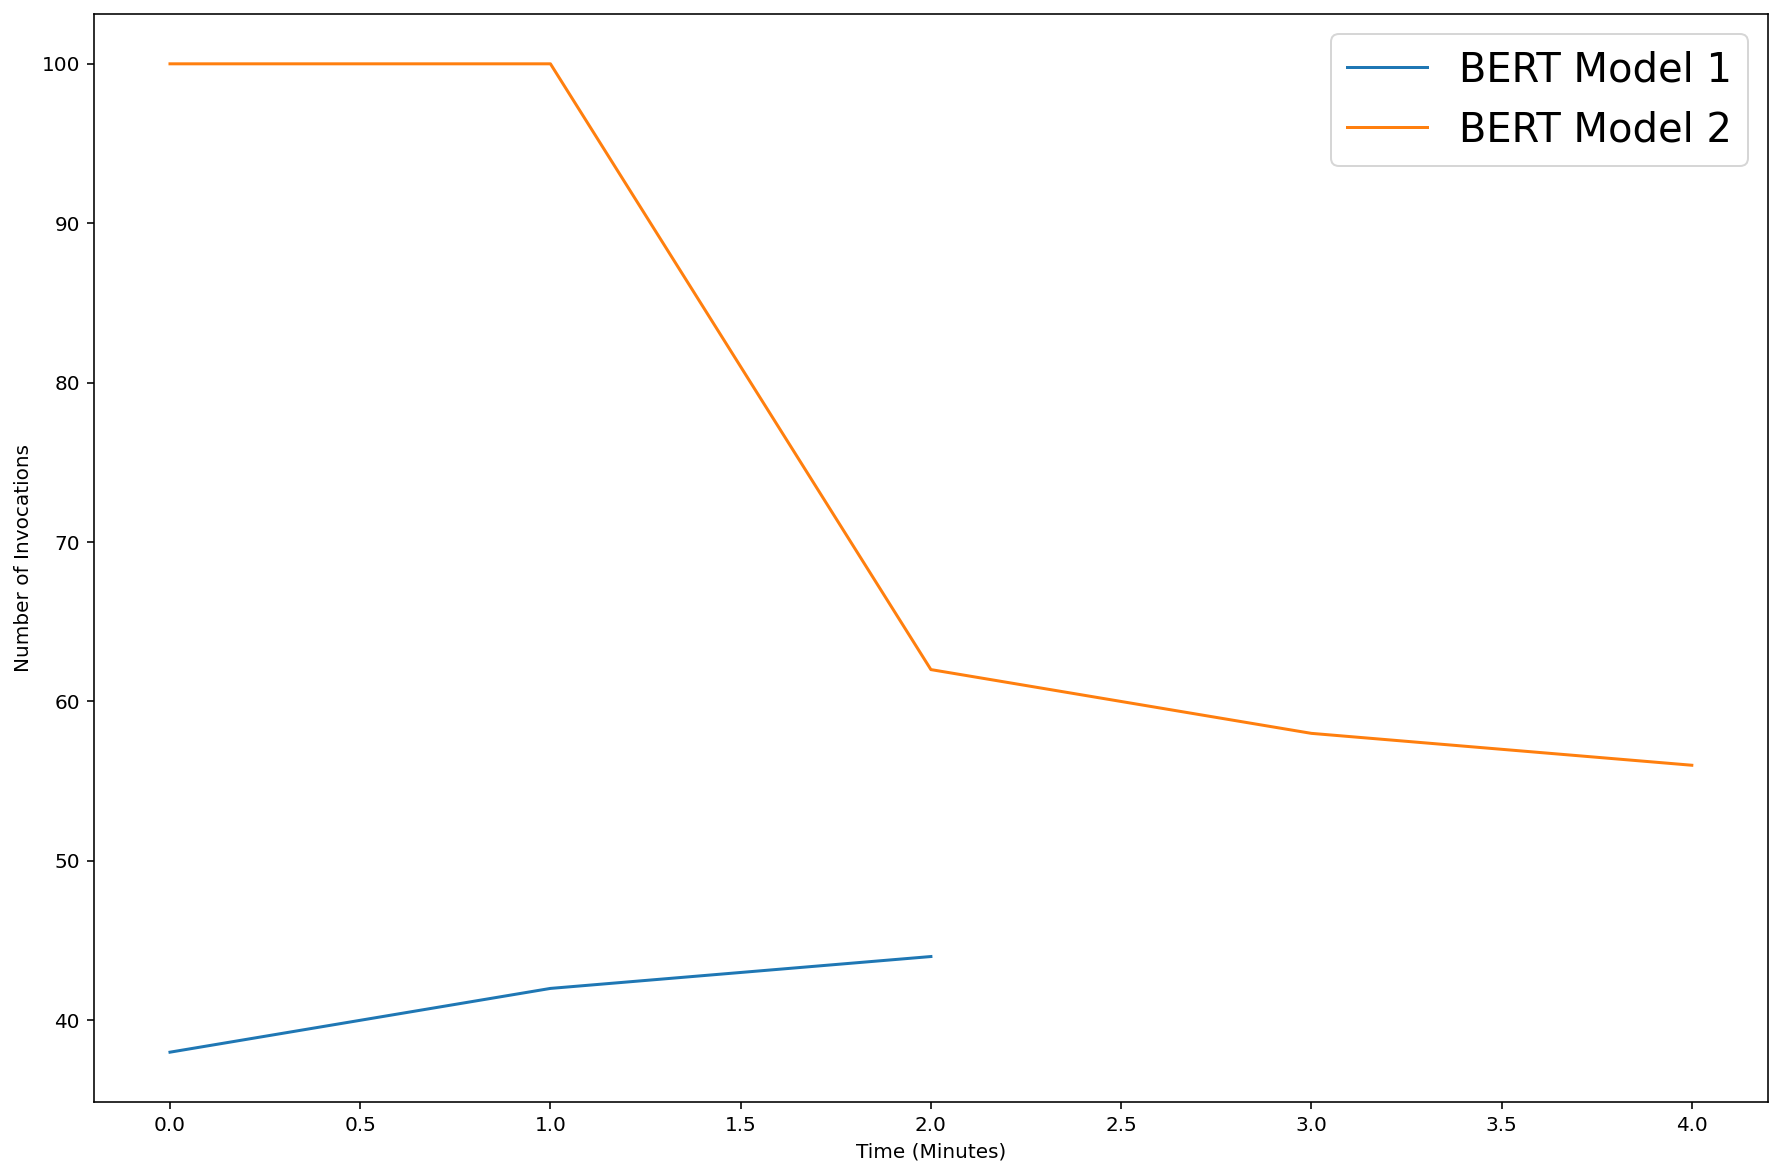

In [59]:
rcParams['figure.figsize'] = 15, 10

x1 = range(0, model_1_endpoint_invocations.size)
y1 = model_1_endpoint_invocations['AllTraffic']
plt.plot(x1, y1, label="BERT Model 1")

x1 = range(0, model_2_endpoint_invocations.size)
y1 = model_2_endpoint_invocations['AllTraffic']
plt.plot(x1, y1, label="BERT Model 2")

plt.legend(loc=0, prop={'size': 20})
plt.xlabel('Time (Minutes)')
plt.ylabel('Number of Invocations')

# Check the Invocation Metrics for the BERT Models

In [60]:
from IPython.core.display import display, HTML
    
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [61]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Visualize Bandit Action Probabilities
This is the probability that the bandit model will choose a particular BERT model (action).

Text(0, 0.5, 'Action Probability')

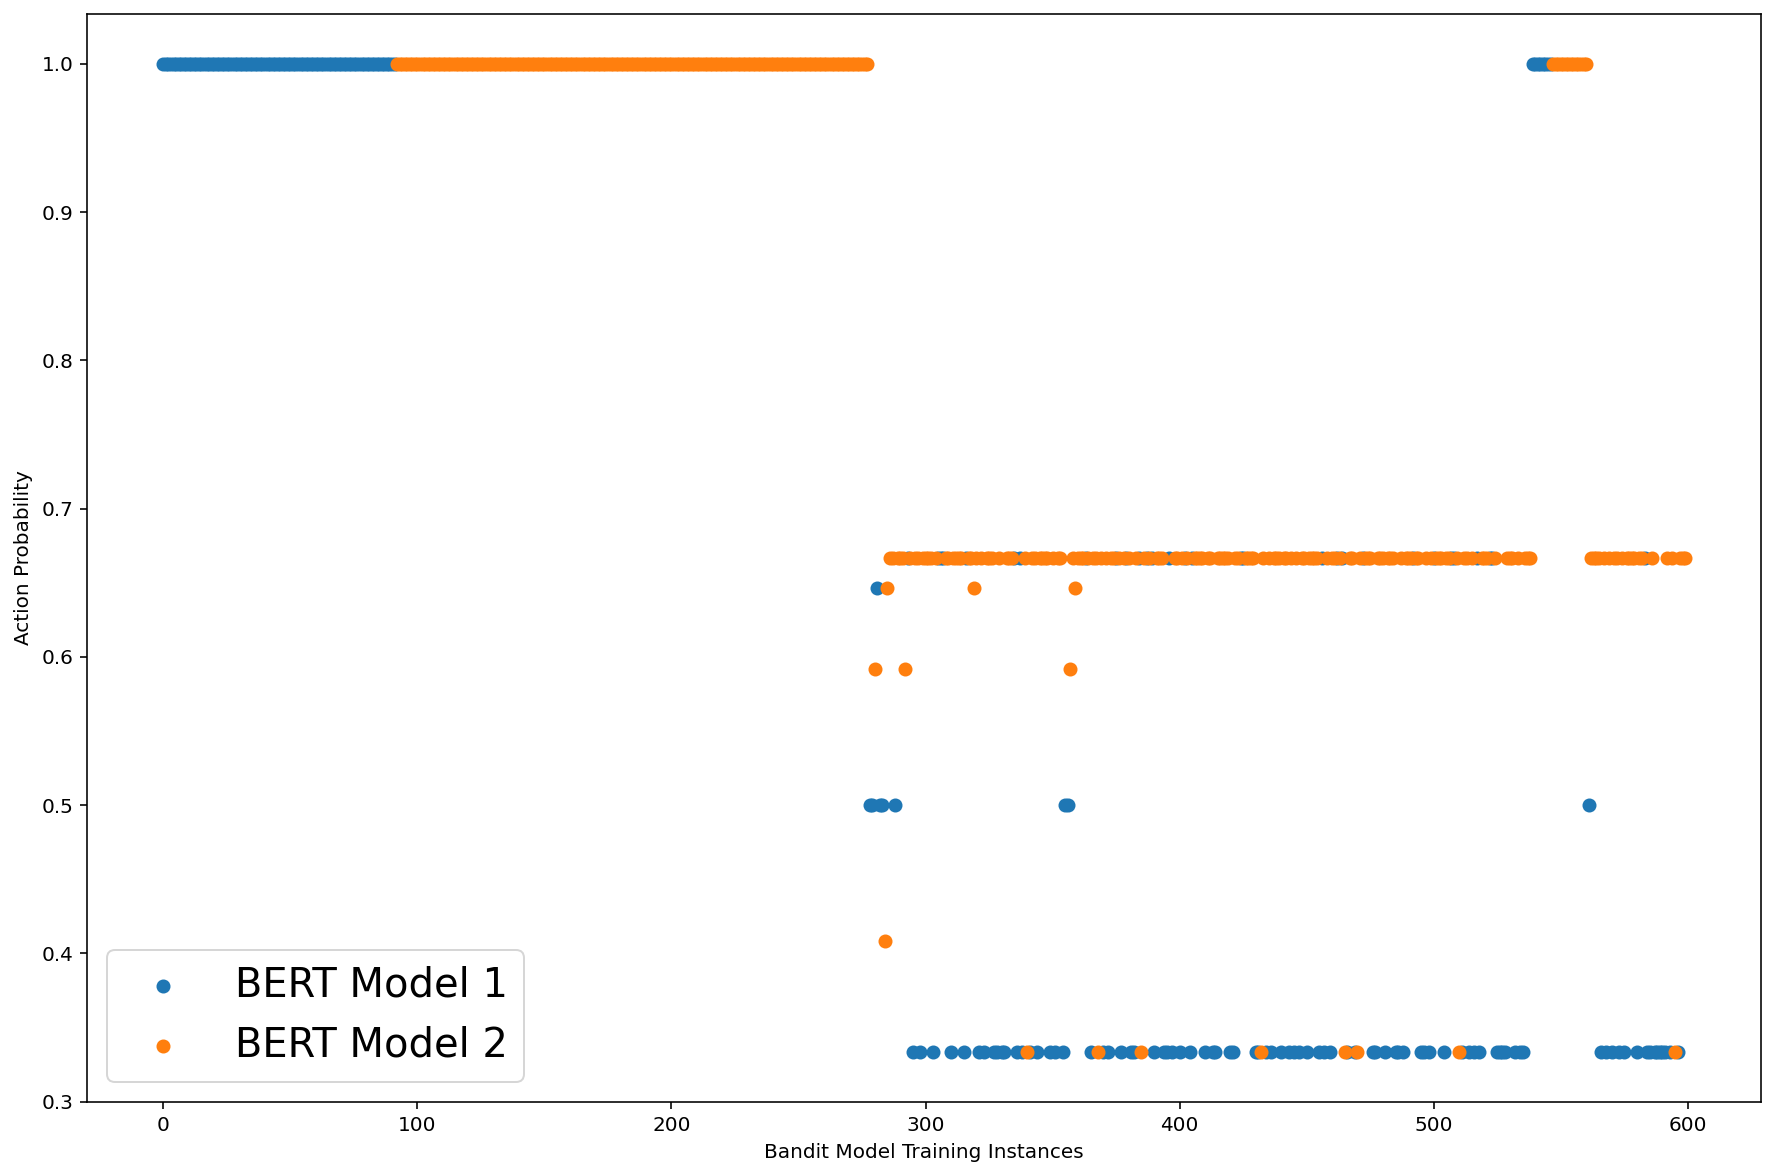

In [62]:
rcParams['figure.figsize'] = 15, 10

x1 = all_joined_data_df.query('action==1').index
y1 = all_joined_data_df.query('action==1').action_prob
plt.scatter(x1, y1, label="BERT Model 1")

x2 = all_joined_data_df.query('action==2').index
y2 = all_joined_data_df.query('action==2').action_prob
plt.scatter(x2, y2, label="BERT Model 2")

plt.legend(loc=3, prop={'size': 20})
plt.xlabel('Bandit Model Training Instances')
plt.ylabel('Action Probability')

In [63]:
print('Mean action probability for BERT Model 1: {}'.format(all_joined_data_df.query('action==1')['action_prob'].mean()))

Mean action probability for BERT Model 1: 0.6829453660714292


In [64]:
print('Mean action probability for BERT Model 2: {}'.format(all_joined_data_df.query('action==2')['action_prob'].mean()))

Mean action probability for BERT Model 2: 0.8354332340425535


# Visualize Bandit Sample Probabilities
Despite the action probability, we sample from all actions (BERT models).  Below is the sample probability for the chosen BERT model.

Text(0, 0.5, 'Sample Probability')

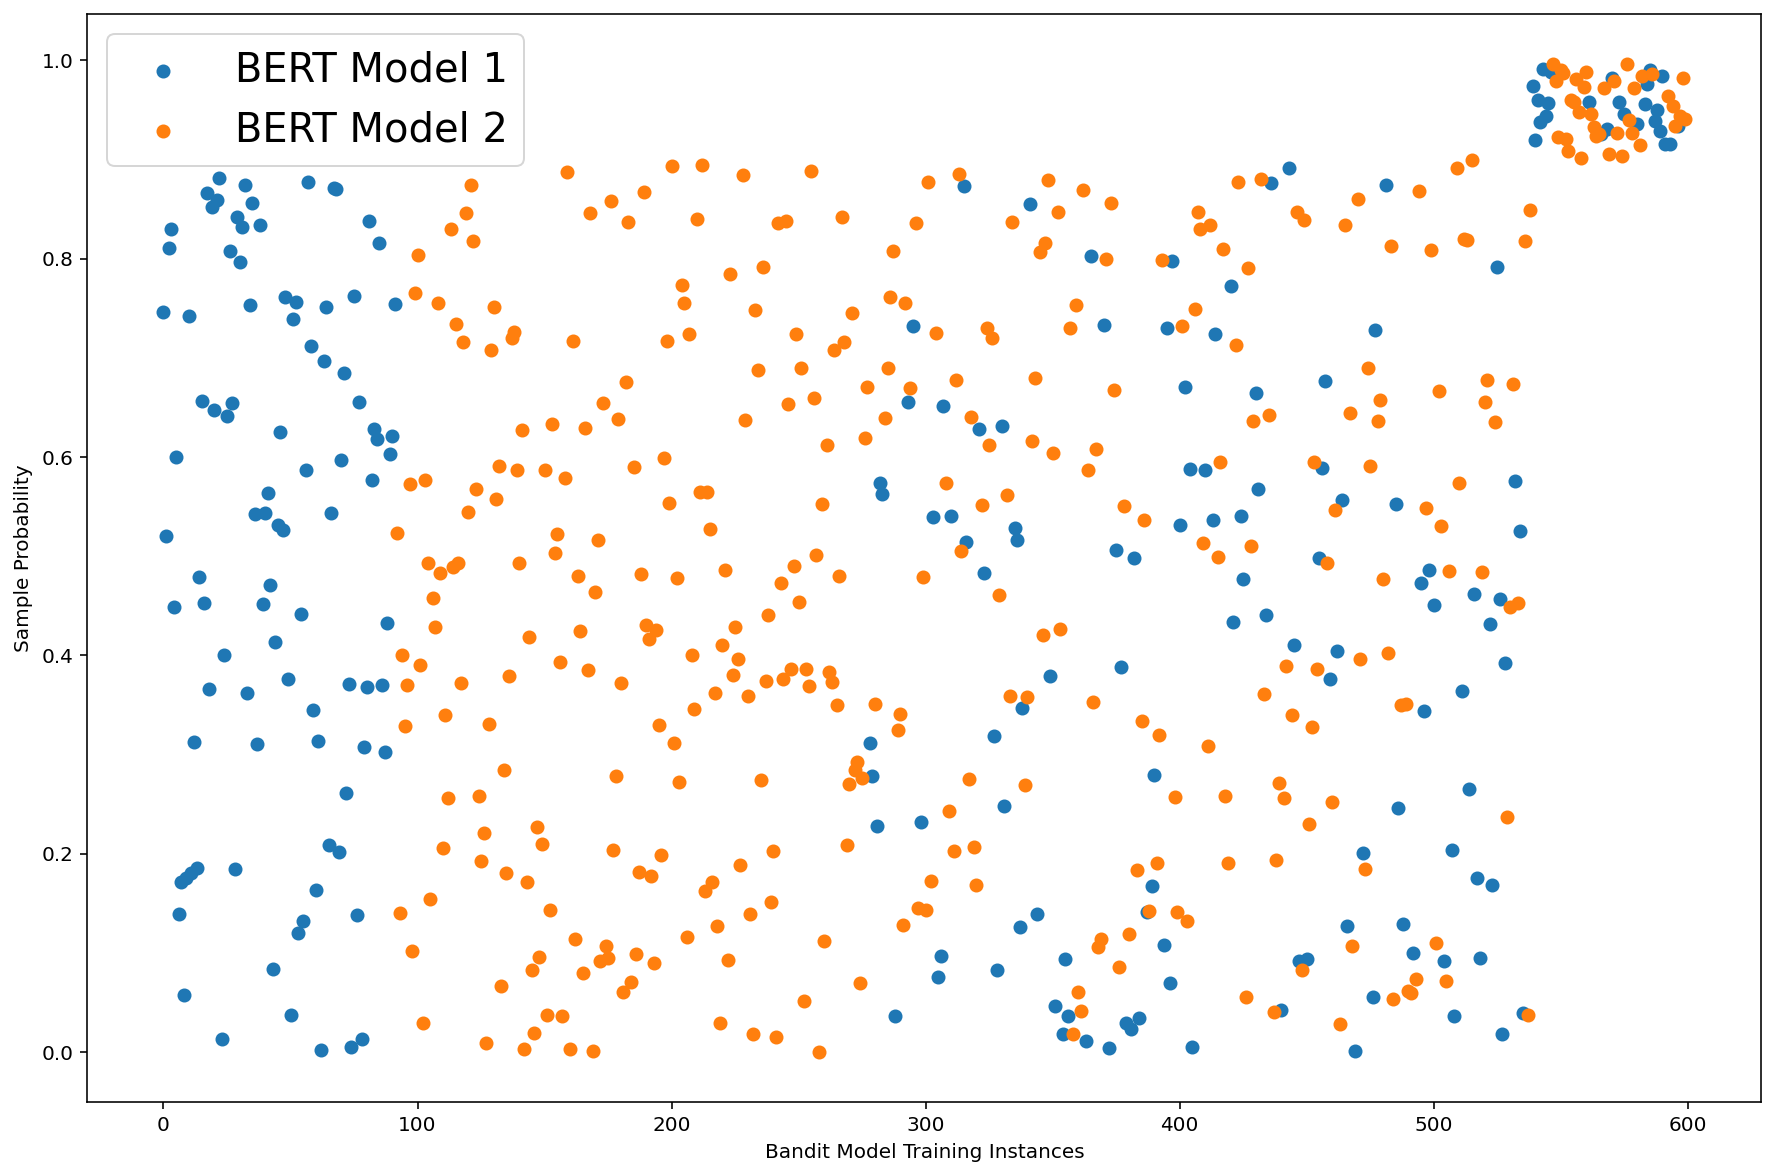

In [65]:
rcParams['figure.figsize'] = 15, 10

x1 = all_joined_data_df.query('action==1').index
y1 = all_joined_data_df.query('action==1').sample_prob
plt.scatter(x1, y1, label="BERT Model 1")

x2 = all_joined_data_df.query('action==2').index
y2 = all_joined_data_df.query('action==2').sample_prob
plt.scatter(x2, y2, label="BERT Model 2")

plt.legend(loc=0, prop={'size': 20})
plt.xlabel('Bandit Model Training Instances')
plt.ylabel('Sample Probability')

In [66]:
print('Mean sample probability for BERT Model 1: {}'.format(all_joined_data_df.query('action==1')['sample_prob'].mean()))

Mean sample probability for BERT Model 1: 0.4980727158016413


In [67]:
print('Mean sample probability for BERT Model 2: {}'.format(all_joined_data_df.query('action==2')['sample_prob'].mean()))

Mean sample probability for BERT Model 2: 0.5077194602314835


# Visualize Bandit Rewards

You can visualize the bandit-model training performance by plotting the rolling mean reward across client interactions.

Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction.

In [68]:
rolling_window = 100

rcParams['figure.figsize'] = 15, 10
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

rewards_df = pd.DataFrame(rewards_list, columns=['bandit']).rolling(rolling_window).mean()
#rewards_df['perfect'] = sum(client_app.optimal_rewards) / len(client_app.optimal_rewards)

rewards_df.tail(10)

,bandit
490,0.33
491,0.33
492,0.33
493,0.32
494,0.32
495,0.32
496,0.32
497,0.31
498,0.30
499,0.30


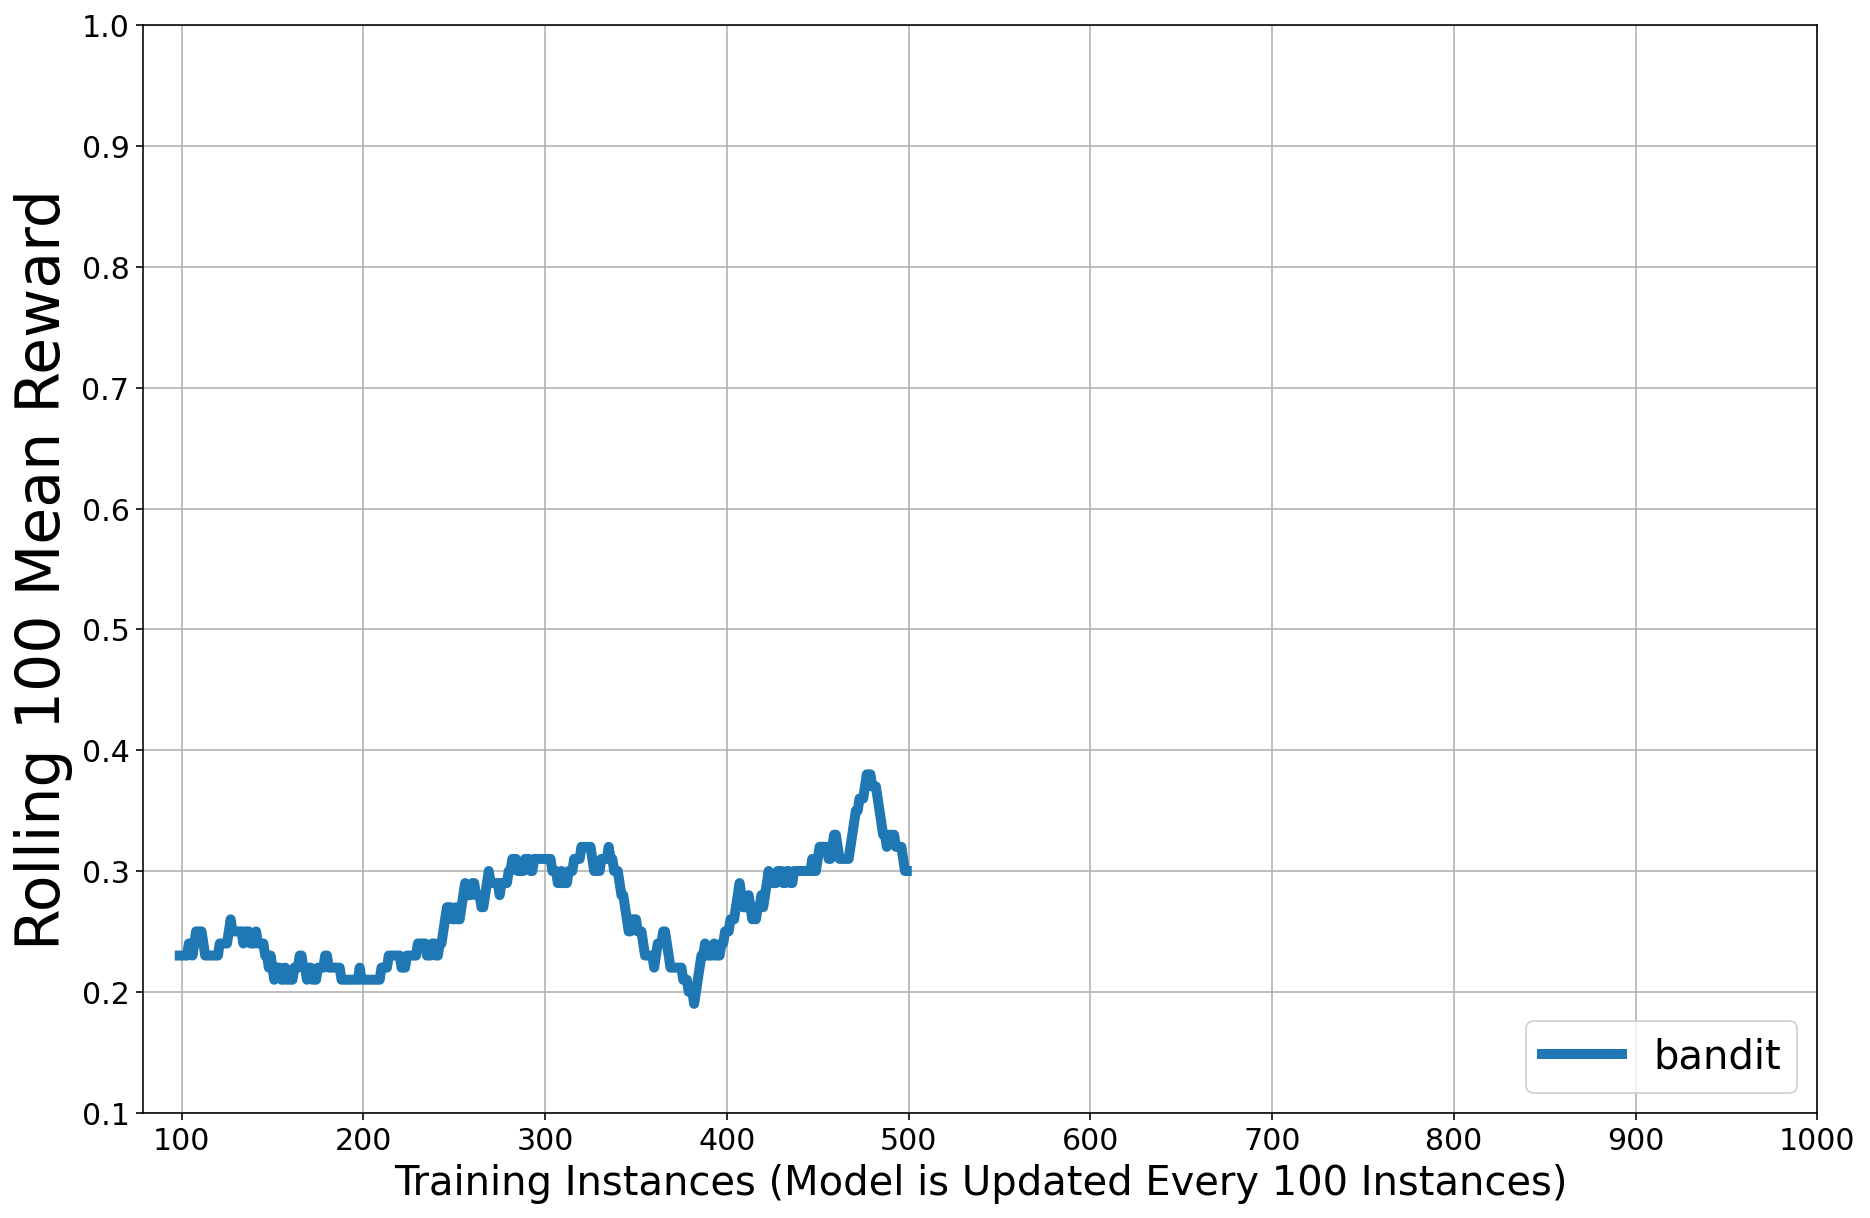

In [69]:
rewards_df.plot(y=['bandit'],  #, 'perfect'], 
                linewidth=lwd)
plt.legend(loc=4, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

plt.xlabel('Training Instances (Model is Updated Every %s Instances)' % retrain_batch_size, size=20)
plt.ylabel('Rolling {} Mean Reward'.format(rolling_window), size=30)
plt.grid()
plt.show()

In [70]:
rewards_df['bandit'].mean()

0.2651870324189525

# Monitor the Bandit Model in CloudWatch

In [71]:
from markdown_helper import *
from IPython.display import Markdown

display(Markdown(bandit_experiment_manager.get_cloudwatch_dashboard_details()))

You can monitor your Training/Hosting evaluation metrics on this [CloudWatch Dashboard](https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=bandits-1605218473;start=PT1H)

(Note: This would need Trained/Hosted Models to be evaluated in order to publish Evaluation Scores)

# Review the DynamoDB Tables and S3 Data

In [72]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/dynamodb/home?region={}#tables:selected=BanditsExperimentTable;tab=items">Bandits Experiment DynamoDB Table</a></b>'.format(region)))


In [73]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">Bandits Experiment S3 Data</a></b>'.format(bucket, bandit_experiment_manager.experiment_id, region)))


# Clean Up

We have three DynamoDB tables from the bandits application above.  To better maintain them, we should remove the related records if the experiment has finished. 

Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. 

_The CloudWatch metrics will be removed during this cleanup step._

In [74]:
print('Cleaning up experiment_id {}'.format(bandit_experiment_manager.experiment_id))
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1605218473'...


Cleaning up experiment_id bandits-1605218473


Gracefully stopping... (press Ctrl+C again to force)


In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();